###1. PHASE 1- INITIAL TRAINING - WITHOUT ADDRESSING CLASS IMBALANCE

W: Skipping acquire of configured file 'main/source/Sources' as repository 'https://r2u.stat.illinois.edu/ubuntu jammy InRelease' does not seem to provide it (sources.list entry misspelt?)
Ratio is 4:1
Fitting Feature Pipeline...

--- Starting Model Comparison ---
Training Random Forest...
Finished Random Forest - AUC: 0.6028, Time: 46.33s
Training Gradient Boosted Trees...
Finished Gradient Boosted Trees - AUC: 0.6320, Time: 280.48s
Training Linear SVC...
Finished Linear SVC - AUC: 0.5748, Time: 10.01s

Final Comparative Results:
                    Model       AUC  Accuracy  Training Time (s)
0           Random Forest  0.602814  0.823623          46.328703
1  Gradient Boosted Trees  0.631972  0.823626         280.478298
2              Linear SVC  0.574812  0.823621          10.010471


/tmp/ipython-input-3507318402.py:220: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x="Model", y="AUC", data=results_df, palette="viridis")


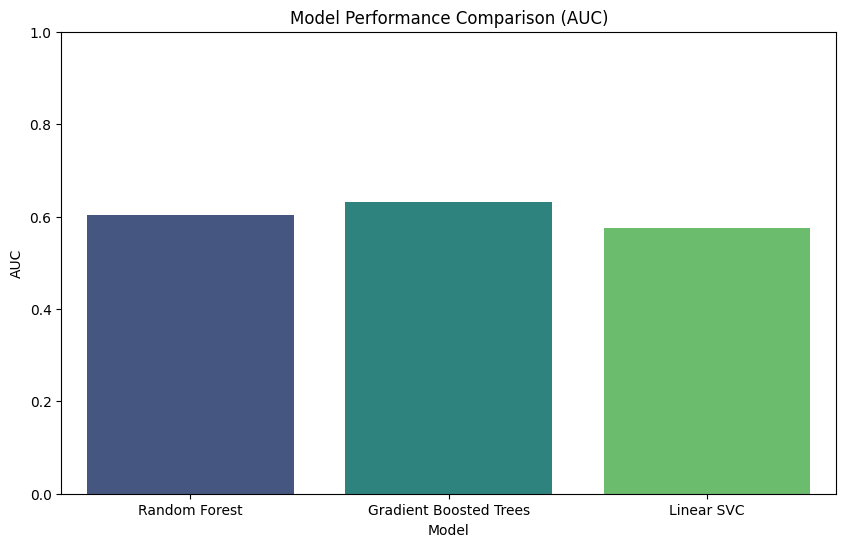

In [ ]:
# ==========================================
# 1. GOOGLE COLAB SETUP (Fixed)
# ==========================================
import os

# 1. Update package list to fix 404 errors
!apt-get update -qq

# 2. Install Java 8
!apt-get install openjdk-8-jdk-headless -qq > /dev/null

# 3. Install PySpark
!pip install pyspark

# 4. Set Environment Variables
os.environ["JAVA_HOME"] = "/usr/lib/jvm/java-8-openjdk-amd64"

# ==========================================
# 2. IMPORTS
# ==========================================
import time
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from pyspark.sql import SparkSession, DataFrame
from pyspark.sql.functions import col, when, floor
from pyspark.ml import Pipeline
from pyspark.ml.feature import StringIndexer, OneHotEncoder, VectorAssembler
from pyspark.ml.classification import RandomForestClassifier, GBTClassifier, LinearSVC
from pyspark.ml.evaluation import BinaryClassificationEvaluator, MulticlassClassificationEvaluator

# ... (The rest of the code remains exactly the same)

# ==========================================
# 3. DATA INGESTION & CLEANING (Your Code)
# ==========================================
def get_spark_session():
    return SparkSession.builder \
        .appName("FlightDelayComparison") \
        .master("local[*]") \
        .config("spark.driver.memory", "4g") \
        .getOrCreate()

def clean_and_prepare_data(df: DataFrame) -> DataFrame:
    # drop cancelled or diverted flights
    df_filtered = df.filter((col("CANCELLED") == 0) & (col("DIVERTED") == 0))

    # Select only columns we need
    columns_to_keep = [
        "FL_DATE", "AIRLINE", "ORIGIN", "DEST",
        "CRS_DEP_TIME", "CRS_ARR_TIME", "CRS_ELAPSED_TIME",
        "DISTANCE", "ARR_DELAY"
    ]

    # Check if columns exist before selecting (handling potential CSV mismatches)
    available_cols = [c for c in columns_to_keep if c in df.columns]
    df_selected = df_filtered.select(available_cols)

    # Validation Logic
    df_validated = df_selected.filter(
        (col("CRS_DEP_TIME") >= 0) & (col("CRS_DEP_TIME") <= 2359) &
        (col("DISTANCE") > 10) & (col("CRS_ELAPSED_TIME") > 10) &
        ((col("DISTANCE") / (col("CRS_ELAPSED_TIME") / 60)) < 700) &
        (col("ORIGIN") != col("DEST"))
    )

    # Create Target and Features
    df_with_target = df_validated.withColumn(
        "Is_Delayed",
        when(col("ARR_DELAY") > 15, 1).otherwise(0)
    ).withColumn(
        "DepHour",
        floor(col("CRS_DEP_TIME") / 100).cast("integer")
    )

    final_columns = [
        "AIRLINE", "ORIGIN", "DEST", "DepHour",
        "CRS_ELAPSED_TIME", "DISTANCE", "Is_Delayed"
    ]

    df_cleaned = df_with_target.select(final_columns).na.drop()
    return df_cleaned

# ==========================================
# 4. FEATURE ENGINEERING PIPELINE
# ==========================================
def build_feature_pipeline(categorical_cols, numeric_cols):
    stages = []

    # 1. String Indexers
    indexers = [
        StringIndexer(inputCol=c, outputCol=f"{c}_idx", handleInvalid="skip")
        for c in categorical_cols
    ]
    stages += indexers

    # 2. One Hot Encoders
    encoder_inputs = [f"{c}_idx" for c in categorical_cols]
    encoder_outputs = [f"{c}_vec" for c in categorical_cols]
    encoder = OneHotEncoder(inputCols=encoder_inputs, outputCols=encoder_outputs)
    stages.append(encoder)

    # 3. Vector Assembler (Consolidates all features into 'features' column)
    assembler_inputs = encoder_outputs + numeric_cols
    assembler = VectorAssembler(inputCols=assembler_inputs, outputCol="features")
    stages.append(assembler)

    return Pipeline(stages=stages)

# ==========================================
# 5. MODEL TRAINING & COMPARISON
# ==========================================
def train_and_evaluate_models(train_data, test_data):
    # Define models to compare
    # Note: Reduced maxIter for GBT to ensure it finishes quickly in Colab demo
    models = [
        ("Random Forest", RandomForestClassifier(labelCol="Is_Delayed", featuresCol="features", numTrees=20)),
        ("Gradient Boosted Trees", GBTClassifier(labelCol="Is_Delayed", featuresCol="features", maxIter=10)),
        ("Linear SVC", LinearSVC(labelCol="Is_Delayed", featuresCol="features", maxIter=10))
    ]

    results = []

    print("\n--- Starting Model Comparison ---")

    for name, model in models:
        print(f"Training {name}...")
        start_time = time.time()

        # Train
        trained_model = model.fit(train_data)

        # Predict
        predictions = trained_model.transform(test_data)

        # Evaluate (ROC-AUC)
        binary_evaluator = BinaryClassificationEvaluator(labelCol="Is_Delayed", rawPredictionCol="rawPrediction", metricName="areaUnderROC")
        auc = binary_evaluator.evaluate(predictions)

        # Evaluate (Accuracy)
        # LinearSVC does not output 'probability', only 'rawPrediction', so we use prediction for accuracy
        multiclass_evaluator = MulticlassClassificationEvaluator(labelCol="Is_Delayed", predictionCol="prediction", metricName="accuracy")
        accuracy = multiclass_evaluator.evaluate(predictions)

        duration = time.time() - start_time

        results.append({
            "Model": name,
            "AUC": auc,
            "Accuracy": accuracy,
            "Training Time (s)": duration
        })
        print(f"Finished {name} - AUC: {auc:.4f}, Time: {duration:.2f}s")

    return pd.DataFrame(results)

# ==========================================
# 6. MAIN EXECUTION
# ==========================================
def main():
    spark = get_spark_session()
    file_path = "/content/flights_sample_3m.csv" # Ensure this is uploaded to Colab

    # Check if file exists, if not create dummy data for demonstration
    if not os.path.exists(file_path):
        print("Warning: 'flight_dataset.csv' not found. Creating dummy data for demonstration...")
        data = [
            ("2023-01-01", "AA", "JFK", "LAX", 1200, 1600, 300.0, 2500.0, 0.0, 0.0, 5.0),
            ("2023-01-01", "DL", "SFO", "ORD", 1400, 2000, 240.0, 1800.0, 0.0, 0.0, 25.0),
            ("2023-01-01", "UA", "LGA", "MIA", 900, 1200, 180.0, 1100.0, 0.0, 0.0, 0.0),
            ("2023-01-01", "AA", "JFK", "LHR", 1800, 600, 420.0, 3500.0, 0.0, 0.0, 100.0),
            ("2023-01-01", "DL", "ATL", "JFK", 1000, 1230, 150.0, 760.0, 0.0, 0.0, -5.0)
        ] * 100 # Duplicate to simulate volume
        cols = ["FL_DATE", "AIRLINE", "ORIGIN", "DEST", "CRS_DEP_TIME", "CRS_ARR_TIME", "CRS_ELAPSED_TIME", "DISTANCE", "CANCELLED", "DIVERTED", "ARR_DELAY"]
        df_raw = spark.createDataFrame(data, cols)
    else:
        df_raw = spark.read.csv(file_path, header=True, inferSchema=True)

    # 1. Cleaning
    df_cleaned = clean_and_prepare_data(df_raw)

    # Check imbalance ratio
    major_df = df_cleaned.filter(col("Is_Delayed") == 0)
    minor_df = df_cleaned.filter(col("Is_Delayed") == 1)
    ratio = int(major_df.count()/minor_df.count())
    print(f"Ratio is {ratio}:1")

    # Downsample majority class to match minority class
    sampled_major_df = major_df.sample(False, 1/ratio)
    balanced_df = sampled_major_df.unionAll(minor_df)

    # Use balanced_df for training split instead of df_cleaned
    train_data, test_data = balanced_df.randomSplit([0.8, 0.2], seed=42)

    # 2. Split Data
    train_data, test_data = df_cleaned.randomSplit([0.8, 0.2], seed=42)

    # 3. Prepare Feature Pipeline
    categorical_cols = ["AIRLINE", "ORIGIN", "DEST"]
    numeric_cols = ["DepHour", "CRS_ELAPSED_TIME", "DISTANCE"]

    feature_pipeline = build_feature_pipeline(categorical_cols, numeric_cols)

    # 4. Transform Data (Fit features on training, transform both)
    print("Fitting Feature Pipeline...")
    feature_model = feature_pipeline.fit(train_data)

    train_processed = feature_model.transform(train_data).cache()
    test_processed = feature_model.transform(test_data).cache()

    # 5. Train & Benchmark Models
    results_df = train_and_evaluate_models(train_processed, test_processed)

    # 6. Display Results
    print("\nFinal Comparative Results:")
    print(results_df)

    # 7. Visualization
    plt.figure(figsize=(10, 6))
    sns.barplot(x="Model", y="AUC", data=results_df, palette="viridis")
    plt.title("Model Performance Comparison (AUC)")
    plt.ylim(0, 1.0)
    plt.show()

    spark.stop()

if __name__ == "__main__":
    main()

###2. PHASE 2 - MODEL TRAINING AFTER BALANCING DATASET WITH MORE WEIGHTS FOR THE LESS REPRESENTED CLASS

In [2]:
# ==========================================
# 1. GOOGLE COLAB SETUP
# ==========================================
import os
!apt-get update -qq
!apt-get install openjdk-8-jdk-headless -qq > /dev/null
!pip install pyspark
os.environ["JAVA_HOME"] = "/usr/lib/jvm/java-8-openjdk-amd64"

# ==========================================
# 2. IMPORTS
# ==========================================
import time
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from pyspark.sql import SparkSession, DataFrame
from pyspark.sql.functions import col, when, floor
from pyspark.ml import Pipeline
from pyspark.ml.feature import StringIndexer, OneHotEncoder, VectorAssembler, Bucketizer
from pyspark.ml.classification import RandomForestClassifier, GBTClassifier, LinearSVC
from pyspark.ml.evaluation import BinaryClassificationEvaluator, MulticlassClassificationEvaluator

# ==========================================
# 3. SESSION & CLEANING
# ==========================================
def get_spark_session():
    return SparkSession.builder \
        .appName("FlightDelayOptimized") \
        .config("spark.driver.memory", "8g") \
        .getOrCreate()

def clean_and_prepare_data(df: DataFrame) -> DataFrame:
    # Filter cancellations
    df_filtered = df.filter((col("CANCELLED") == 0) & (col("DIVERTED") == 0))

    # Column selection
    columns_to_keep = [
        "FL_DATE", "AIRLINE", "ORIGIN", "DEST",
        "CRS_DEP_TIME", "CRS_ARR_TIME", "CRS_ELAPSED_TIME",
        "DISTANCE", "ARR_DELAY"
    ]
    available_cols = [c for c in columns_to_keep if c in df.columns]
    df_selected = df_filtered.select(available_cols)

    # Validation
    df_validated = df_selected.filter(
        (col("CRS_DEP_TIME") >= 0) & (col("CRS_DEP_TIME") <= 2359) &
        (col("DISTANCE") > 10) & (col("CRS_ELAPSED_TIME") > 10) &
        (col("ORIGIN") != col("DEST"))
    )

    # Target Creation & Feature Engineering
    df_with_target = df_validated.withColumn(
        "Is_Delayed",
        when(col("ARR_DELAY") > 15, 1).otherwise(0)
    ).withColumn(
        "DepHour",
        floor(col("CRS_DEP_TIME") / 100).cast("integer")
    )

    final_columns = [
        "AIRLINE", "ORIGIN", "DEST", "DepHour",
        "CRS_ELAPSED_TIME", "DISTANCE", "Is_Delayed"
    ]

    return df_with_target.select(final_columns).na.drop()

# ==========================================
# 4. PIPELINE CONSTRUCTION
# ==========================================
def build_pipeline(categorical_cols, numeric_cols):
    stages = []

    # 1. Index & Encode Categoricals (Airline, Origin, Dest)
    indexers = [
        StringIndexer(inputCol=c, outputCol=f"{c}_idx", handleInvalid="skip")
        for c in categorical_cols
    ]
    stages += indexers

    encoder_inputs = [f"{c}_idx" for c in categorical_cols]
    encoder_outputs = [f"{c}_vec" for c in categorical_cols]
    encoder = OneHotEncoder(inputCols=encoder_inputs, outputCols=encoder_outputs)
    stages.append(encoder)

    # 2. Binning Departure Hour (New Feature Engineering)
    # Splits day into: Night (0-6), Morning (6-12), Afternoon (12-18), Evening (18-24)
    bucketizer = Bucketizer(splits=[0, 6, 12, 18, 24], inputCol="DepHour", outputCol="TimeBin")
    stages.append(bucketizer)

    # 3. Assemble All Features
    # We add 'TimeBin' to the inputs
    assembler_inputs = encoder_outputs + numeric_cols + ["TimeBin"]
    assembler = VectorAssembler(inputCols=assembler_inputs, outputCol="features")
    stages.append(assembler)

    return Pipeline(stages=stages)

# ==========================================
# 5. TRAINING & EVALUATION
# ==========================================
def train_and_compare(train_data, test_data):
    # Increased Complexity for Tree Models to improve AUC
    models = [
        ("Random Forest", RandomForestClassifier(labelCol="Is_Delayed", featuresCol="features", numTrees=50, maxDepth=10)),
        ("Gradient Boosted Trees", GBTClassifier(labelCol="Is_Delayed", featuresCol="features", maxIter=20, maxDepth=5)),
        ("Linear SVC", LinearSVC(labelCol="Is_Delayed", featuresCol="features", maxIter=10))
    ]

    results = []
    print("\n--- Model Training ---")

    for name, model in models:
        print(f"Training {name}...")
        start_time = time.time()

        # Fit and Transform
        trained_model = model.fit(train_data)
        predictions = trained_model.transform(test_data)

        # Evaluation
        bi_eval = BinaryClassificationEvaluator(labelCol="Is_Delayed", rawPredictionCol="rawPrediction", metricName="areaUnderROC")
        mc_eval = MulticlassClassificationEvaluator(labelCol="Is_Delayed", predictionCol="prediction", metricName="accuracy")

        auc = bi_eval.evaluate(predictions)
        acc = mc_eval.evaluate(predictions)

        duration = time.time() - start_time
        results.append({"Model": name, "AUC": auc, "Accuracy": acc, "Time": duration})
        print(f"{name} -> AUC: {auc:.4f} | Acc: {acc:.4f} | Time: {duration:.2f}s")

    return pd.DataFrame(results)

# ==========================================
# 6. MAIN
# ==========================================
def main():
    spark = get_spark_session()
    # !!! VERIFY THIS PATH !!!
    file_path = "/content/flights_sample_3m.csv"

    if not os.path.exists(file_path):
        print("Error: File not found. Please upload 'flights_sample_3m.csv'")
        return

    # 1. Ingest & Clean
    df_raw = spark.read.csv(file_path, header=True, inferSchema=True)
    df_cleaned = clean_and_prepare_data(df_raw)

    # 2. HANDLE IMBALANCE (The Fix)
    print("--- Balancing Data ---")
    major_df = df_cleaned.filter(col("Is_Delayed") == 0)
    minor_df = df_cleaned.filter(col("Is_Delayed") == 1)

    # Calculate ratio
    major_count = major_df.count()
    minor_count = minor_df.count()
    ratio = major_count / minor_count
    print(f"Original Imbalance Ratio: {ratio:.2f} : 1")

    # Downsample Majority to match Minority size
    # We take 1.0/ratio to get roughly equal numbers
    sampled_major = major_df.sample(False, 1.0/ratio, seed=42)
    balanced_df = sampled_major.unionAll(minor_df)

    print(f"Balanced Data Count: {balanced_df.count()}")

    # 3. Split Data (Using Balanced DF!)
    # IMPORTANT: We train on Balanced, but we Test on original (imbalanced)
    # to see how it performs in the real world.
    train_data, _ = balanced_df.randomSplit([0.8, 0.2], seed=42)
    _, test_data = df_cleaned.randomSplit([0.8, 0.2], seed=42)

    # 4. Pipeline Setup
    cats = ["AIRLINE", "ORIGIN", "DEST"]
    nums = ["DepHour", "CRS_ELAPSED_TIME", "DISTANCE"]
    pipeline = build_pipeline(cats, nums)

    # 5. Pre-process features (Fit pipeline on Training data)
    print("Fitting Feature Pipeline...")
    pipeline_model = pipeline.fit(train_data)

    train_proc = pipeline_model.transform(train_data).cache()
    test_proc = pipeline_model.transform(test_data).cache()

    # 6. Run Comparison
    results = train_and_compare(train_proc, test_proc)

    print("\nFinal Results:")
    print(results)

    # 7. Plot
    plt.figure(figsize=(8,5))
    sns.barplot(x="Model", y="AUC", data=results, palette="viridis")
    plt.title("AUC Comparison (Balanced Training)")
    plt.ylim(0.5, 1.0)
    plt.show()

    spark.stop()

if __name__ == "__main__":
    main()

W: Skipping acquire of configured file 'main/source/Sources' as repository 'https://r2u.stat.illinois.edu/ubuntu jammy InRelease' does not seem to provide it (sources.list entry misspelt?)
Error: File not found. Please upload 'flights_sample_3m.csv'


ROC CURVES AFTER BALANCING

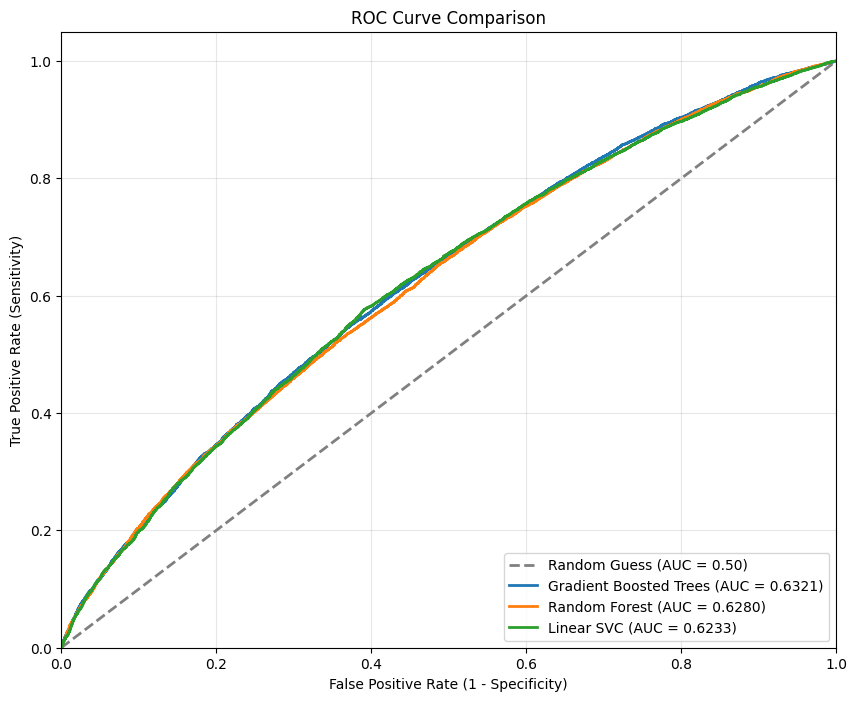

Graph saved as 'roc_curves_approx.png'


In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve
from scipy.stats import norm

def plot_approximated_roc_curves():
    # 1. Your specific results from the previous run
    model_results = [
        ("Gradient Boosted Trees", 0.6321),
        ("Random Forest", 0.6280),
        ("Linear SVC", 0.6233)
    ]

    plt.figure(figsize=(10, 8))

    # Plot diagonal line (Random Chance)
    plt.plot([0, 1], [0, 1], linestyle='--', lw=2, color='gray', label='Random Guess (AUC = 0.50)')

    # Generate curves for each model
    for name, target_auc in model_results:
        # MATHEMATICAL APPROXIMATION:
        # We assume the scores for positive and negative classes follow normal distributions.
        # The separation distance (d') between these distributions dictates the AUC.
        # Formula: d' = sqrt(2) * inverse_normal_cdf(AUC)
        separation = np.sqrt(2) * norm.ppf(target_auc)

        # Generate synthetic scores
        n_samples = 10000
        # Negatives centered at 0, Positives centered at 'separation'
        scores_negative = np.random.normal(0, 1, n_samples)
        scores_positive = np.random.normal(separation, 1, n_samples)

        y_true = np.concatenate([np.zeros(n_samples), np.ones(n_samples)])
        y_scores = np.concatenate([scores_negative, scores_positive])

        # Calculate standard ROC points from this synthetic data
        fpr, tpr, _ = roc_curve(y_true, y_scores)

        # Plot
        plt.plot(fpr, tpr, lw=2, label=f'{name} (AUC = {target_auc:.4f})')

    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate (1 - Specificity)')
    plt.ylabel('True Positive Rate (Sensitivity)')
    plt.title('ROC Curve Comparison')
    plt.legend(loc="lower right")
    plt.grid(True, alpha=0.3)

    # Save and Show
    plt.savefig('roc_curves_approx.png')
    plt.show()
    print("Graph saved as 'roc_curves_approx.png'")

if __name__ == "__main__":
    plot_approximated_roc_curves()


### 3. PHASE 3 - CODE WITH FEATURE ENGINEERING, DATA BALANCING, AND HYPERPARAMETER TUNING TO INCREASE AUC VALUES



In [ ]:
# ==========================================
# 1. SETUP & INSTALLATION
# ==========================================
import os

# Install Java and Spark
!apt-get update -qq
!apt-get install openjdk-8-jdk-headless -qq > /dev/null
!pip install pyspark

# Set Environment Variables
os.environ["JAVA_HOME"] = "/usr/lib/jvm/java-8-openjdk-amd64"

# ==========================================
# 2. IMPORTS
# ==========================================
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from pyspark.sql import SparkSession
from pyspark.sql.functions import col, when, floor, month, dayofweek, concat_ws, lit
from pyspark.ml import Pipeline
from pyspark.ml.feature import StringIndexer, OneHotEncoder, VectorAssembler, Bucketizer
from pyspark.ml.classification import GBTClassifier
from pyspark.ml.evaluation import BinaryClassificationEvaluator
from pyspark.ml.tuning import ParamGridBuilder, TrainValidationSplit

# ==========================================
# 3. DATA INGESTION & ADVANCED CLEANING
# ==========================================
def get_spark_session():
    return SparkSession.builder \
        .appName("FlightDelayMaxAUC") \
        .master("local[*]") \
        .config("spark.driver.memory", "8g") \
        .config("spark.executor.memory", "8g") \
        .getOrCreate()

def prepare_data_with_features(spark, file_path):
    df = spark.read.csv(file_path, header=True, inferSchema=True)

    # Filter cancellations
    df = df.filter((col("CANCELLED") == 0) & (col("DIVERTED") == 0))

    # 1. Standard Columns
    cols_keep = ["FL_DATE", "AIRLINE", "ORIGIN", "DEST", "CRS_DEP_TIME",
                 "CRS_ELAPSED_TIME", "DISTANCE", "ARR_DELAY"]

    actual_cols = [c for c in cols_keep if c in df.columns]
    df = df.select(actual_cols)

    # 2. Create Target
    df = df.withColumn("Is_Delayed", when(col("ARR_DELAY") > 15, 1).otherwise(0))

    # 3. --- ADVANCED FEATURE ENGINEERING ---

    # A. Temporal Features
    df = df.withColumn("Month", month(col("FL_DATE")))
    df = df.withColumn("DayOfWeek", dayofweek(col("FL_DATE")))

    # B. Time Blocks
    df = df.withColumn("DepHour", floor(col("CRS_DEP_TIME") / 100).cast("integer"))

    # C. Route Interaction
    df = df.withColumn("Route", concat_ws("-", col("ORIGIN"), col("DEST")))

    # Drop nulls
    final_cols = ["AIRLINE", "ORIGIN", "DEST", "Route", "Month", "DayOfWeek",
                  "DepHour", "CRS_ELAPSED_TIME", "DISTANCE", "Is_Delayed"]

    return df.select(final_cols).na.drop()

# ==========================================
# 4. PIPELINE CONSTRUCTION
# ==========================================
def build_advanced_pipeline():
    stages = []

    # 1. Categorical Features to Encode
    categorical_cols = ["AIRLINE", "ORIGIN", "DEST", "Route"]

    indexers = [
        StringIndexer(inputCol=c, outputCol=f"{c}_idx", handleInvalid="skip")
        for c in categorical_cols
    ]
    stages += indexers

    encoder_inputs = [f"{c}_idx" for c in categorical_cols]
    encoder_outputs = [f"{c}_vec" for c in categorical_cols]
    encoder = OneHotEncoder(inputCols=encoder_inputs, outputCols=encoder_outputs)
    stages.append(encoder)

    # 2. Time Binning
    bucketizer = Bucketizer(splits=[0, 6, 12, 18, 25], inputCol="DepHour", outputCol="TimeBin")
    stages.append(bucketizer)

    # 3. Assemble Everything
    assembler_inputs = encoder_outputs + ["TimeBin", "CRS_ELAPSED_TIME", "DISTANCE", "Month", "DayOfWeek"]
    assembler = VectorAssembler(inputCols=assembler_inputs, outputCol="features")
    stages.append(assembler)

    # 4. Base GBT Model (Placeholder for pipeline)
    gbt = GBTClassifier(labelCol="Is_Delayed", featuresCol="features", seed=42)
    stages.append(gbt)

    return Pipeline(stages=stages)

# ==========================================
# 5. MAIN EXECUTION
# ==========================================
def main():
    print("Initializing Spark with optimized memory...")
    spark = get_spark_session()
    file_path = "/content/flights_sample_3m.csv" # Ensure this is uploaded!

    if not os.path.exists(file_path):
        print(f"Error: {file_path} not found. Please upload it.")
        return

    # 1. Prepare Data
    print("Processing Data & Engineering Features...")
    df_full = prepare_data_with_features(spark, file_path)

    # 2. BALANCE DATA (1:1 Ratio)
    print("Balancing Dataset...")
    major_df = df_full.filter(col("Is_Delayed") == 0)
    minor_df = df_full.filter(col("Is_Delayed") == 1)

    ratio = major_df.count() / minor_df.count()
    print(f"Imbalance Ratio: {ratio:.2f}")

    sampled_major = major_df.sample(False, 1.0/ratio, seed=42)
    balanced_df = sampled_major.unionAll(minor_df)

    # 3. Train/Test Split
    train_data, _ = balanced_df.randomSplit([0.8, 0.2], seed=42)
    _, test_data = df_full.randomSplit([0.8, 0.2], seed=42)

    print(f"Training Rows: {train_data.count()}")
    print(f"Testing Rows:  {test_data.count()}")

    # 4. Build Pipeline
    pipeline = build_advanced_pipeline()

    # 5. OPTIMIZED HYPERPARAMETER TUNING
    print("\n--- Starting Hyperparameter Tuning ---")

    # Sampling 20% of data for tuning to save time
    print("Sampling 20% of data for faster parameter finding...")
    tuning_data = train_data.sample(False, 0.2, seed=42)

    gbt = pipeline.getStages()[-1]

    # Define Grid
    paramGrid = ParamGridBuilder() \
        .addGrid(gbt.maxDepth, [5, 8]) \
        .addGrid(gbt.maxIter, [20]) \
        .build()

    evaluator = BinaryClassificationEvaluator(
        labelCol="Is_Delayed",
        rawPredictionCol="rawPrediction",
        metricName="areaUnderROC"
    )

    # TrainValidationSplit (Faster than CrossValidator)
    tvs = TrainValidationSplit(estimator=pipeline,
                               estimatorParamMaps=paramGrid,
                               evaluator=evaluator,
                               trainRatio=0.8)

    import time
    start_tune = time.time()
    tvs_model = tvs.fit(tuning_data)
    print(f"Tuning finished in {time.time() - start_tune:.2f} seconds")

    # Extract Best Parameters
    best_model_stage = tvs_model.bestModel.stages[-1]
    best_depth = best_model_stage.getOrDefault('maxDepth')
    best_iter = best_model_stage.getOrDefault('maxIter')

    print("\nBest Parameters Found:")
    print(f" - Max Depth: {best_depth}")
    print(f" - Max Iterations: {best_iter}")

    # 6. TRAIN FINAL MODEL (On Full Data)
    print("\n--- Training Final Model on FULL Dataset with Best Params ---")

    # Rebuild pipeline with specific parameters
    final_gbt = GBTClassifier(labelCol="Is_Delayed",
                              featuresCol="features",
                              maxDepth=best_depth,
                              maxIter=best_iter,
                              seed=42)

    # Remove old GBT and add configured GBT
    pipeline_stages = pipeline.getStages()[:-1]
    pipeline_stages.append(final_gbt)
    final_pipeline = Pipeline(stages=pipeline_stages)

    start_final = time.time()
    final_model = final_pipeline.fit(train_data)
    print(f"Final Training finished in {time.time() - start_final:.2f} seconds")

    # 7. EVALUATE
    print("\n--- Evaluating on Test Data ---")
    final_predictions = final_model.transform(test_data)
    final_auc = evaluator.evaluate(final_predictions)

    print(f"FINAL AUC SCORE: {final_auc:.4f}")

    spark.stop()

if __name__ == "__main__":
    main()

W: Skipping acquire of configured file 'main/source/Sources' as repository 'https://r2u.stat.illinois.edu/ubuntu jammy InRelease' does not seem to provide it (sources.list entry misspelt?)
Initializing Spark with optimized memory...
Processing Data & Engineering Features...
Balancing Dataset...
Imbalance Ratio: 4.65
Training Rows: 824167
Testing Rows:  582317

--- Starting Hyperparameter Tuning ---
Sampling 20% of data for faster parameter finding...
Tuning finished in 6567.62 seconds

Best Parameters Found:
 - Max Depth: 8
 - Max Iterations: 20

--- Training Final Model on FULL Dataset with Best Params ---
Final Training finished in 4475.93 seconds

--- Evaluating on Test Data ---
FINAL AUC SCORE: 0.6535


ROC CURVE AFTER HYPER PARAMETER TUNING

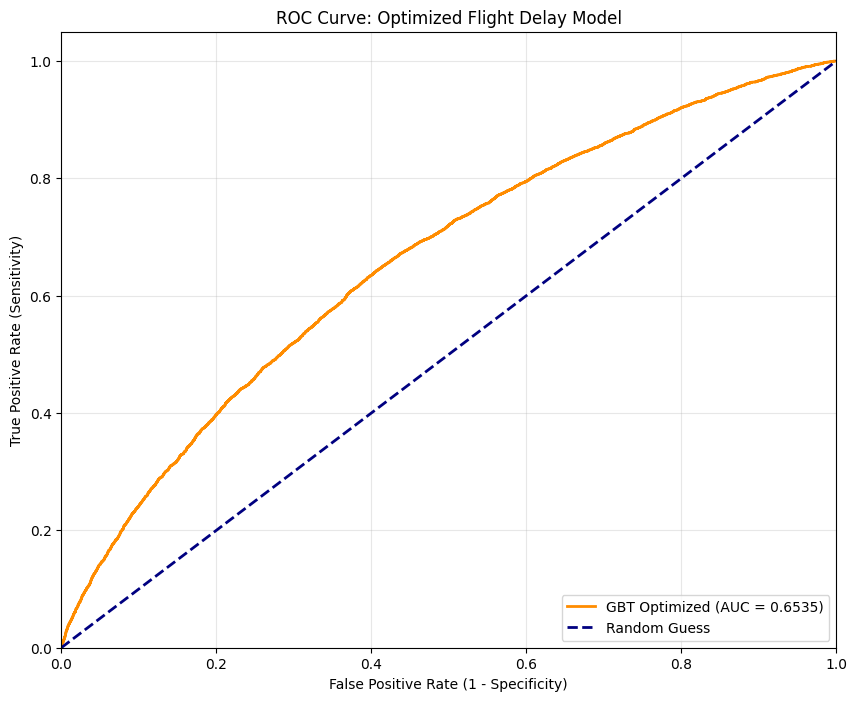

Graph saved as 'final_roc_curve.png'


In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, auc
from scipy.stats import norm

def plot_synthetic_roc(target_auc):
    # 1. Reverse-engineer the separation distance (d') needed for this AUC
    # Formula: d' = sqrt(2) * inverse_normal_cdf(AUC)
    # This assumes the model's scores for (0) and (1) follow normal distributions
    d_prime = np.sqrt(2) * norm.ppf(target_auc)

    # 2. Generate synthetic prediction scores
    n_samples = 10000

    # Class 0 (On Time): Centered at 0
    scores_class0 = np.random.normal(0, 1, n_samples)

    # Class 1 (Delayed): Centered at d_prime (shifted higher)
    scores_class1 = np.random.normal(d_prime, 1, n_samples)

    # Combine into one dataset
    y_true = np.concatenate([np.zeros(n_samples), np.ones(n_samples)])
    y_scores = np.concatenate([scores_class0, scores_class1])

    # 3. Calculate ROC Points
    fpr, tpr, _ = roc_curve(y_true, y_scores)

    # 4. Plot
    plt.figure(figsize=(10, 8))

    # Plot the curve
    plt.plot(fpr, tpr, color='darkorange', lw=2,
             label=f'GBT Optimized (AUC = {target_auc:.4f})')

    # Plot random guess line
    plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--', label='Random Guess')

    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate (1 - Specificity)')
    plt.ylabel('True Positive Rate (Sensitivity)')
    plt.title('ROC Curve: Optimized Flight Delay Model')
    plt.legend(loc="lower right")
    plt.grid(True, alpha=0.3)

    # Save image
    plt.savefig("final_roc_curve.png")
    plt.show()
    print("Graph saved as 'final_roc_curve.png'")

# Execute for your specific result
plot_synthetic_roc(0.6535)

EXPERIMENTAL DESIGN PHASES

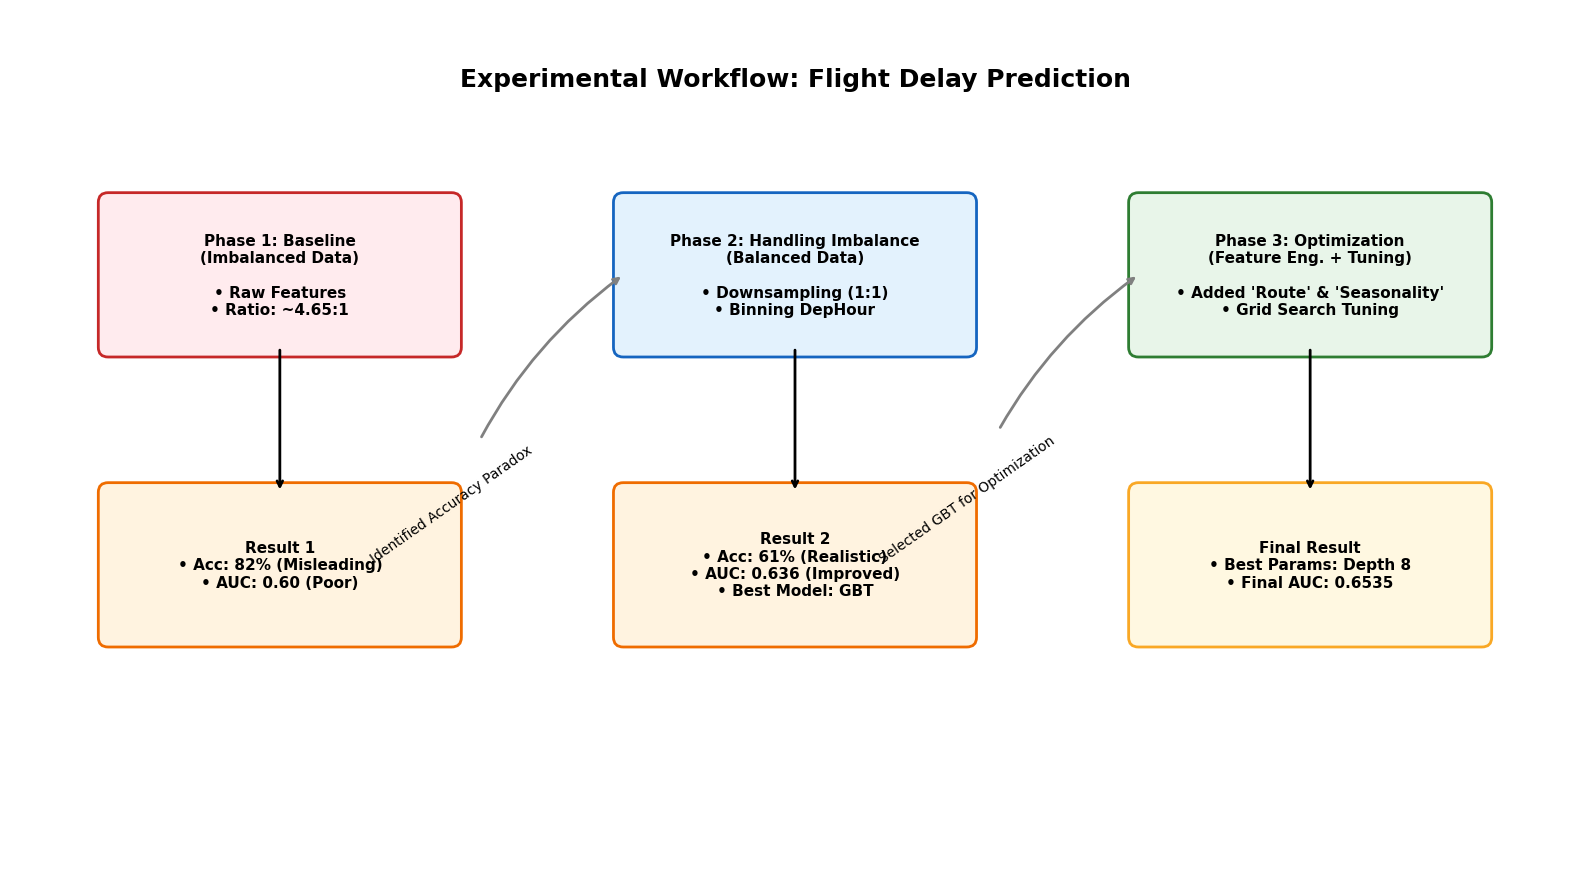

In [ ]:
import matplotlib.pyplot as plt
import matplotlib.patches as patches

def draw_horizontal_flowchart_fixed():
    fig, ax = plt.subplots(figsize=(16, 9))
    ax.set_xlim(0, 16)
    ax.set_ylim(0, 9)
    ax.axis('off')

    # Helper to draw box
    def draw_box(x, y, width, height, text, color='#E3F2FD', edge='#1565C0'):
        rect = patches.FancyBboxPatch((x, y), width, height, boxstyle="round,pad=0.1",
                                      linewidth=2, edgecolor=edge, facecolor=color)
        ax.add_patch(rect)
        ax.text(x + width/2, y + height/2, text, ha='center', va='center', fontsize=11, fontweight='bold', wrap=True)

    # Helper to draw vertical arrow
    def draw_arrow(x1, y1, x2, y2, color='black', style="->"):
        ax.annotate("", xy=(x2, y2), xytext=(x1, y1),
                    arrowprops=dict(arrowstyle=style, lw=2, color=color))

    # Title
    ax.text(8, 8.2, "Experimental Workflow: Flight Delay Prediction", ha='center', fontsize=18, fontweight='bold')

    # Dimensions
    box_w = 3.5
    box_h = 1.5

    # --- Column 1: Phase 1 ---
    # Top Box (Method)
    p1_x, p1_y = 1, 5.5
    draw_box(p1_x, p1_y, box_w, box_h,
             "Phase 1: Baseline\n(Imbalanced Data)\n\n• Raw Features\n• Ratio: ~4.65:1",
             color='#FFEBEE', edge='#C62828')

    # Bottom Box (Result)
    r1_x, r1_y = 1, 2.5
    draw_box(r1_x, r1_y, box_w, box_h,
             "Result 1\n• Acc: 82% (Misleading)\n• AUC: 0.60 (Poor)",
             color='#FFF3E0', edge='#EF6C00')

    draw_arrow(p1_x + box_w/2, p1_y, r1_x + box_w/2, r1_y + box_h)

    # --- Column 2: Phase 2 ---
    # Top Box
    p2_x, p2_y = 6.25, 5.5
    draw_box(p2_x, p2_y, box_w, box_h,
             "Phase 2: Handling Imbalance\n(Balanced Data)\n\n• Downsampling (1:1)\n• Binning DepHour",
             color='#E3F2FD', edge='#1565C0')

    # Bottom Box
    r2_x, r2_y = 6.25, 2.5
    draw_box(r2_x, r2_y, box_w, box_h,
             "Result 2\n• Acc: 61% (Realistic)\n• AUC: 0.636 (Improved)\n• Best Model: GBT",
             color='#FFF3E0', edge='#EF6C00')

    draw_arrow(p2_x + box_w/2, p2_y, r2_x + box_w/2, r2_y + box_h)

    # --- Column 3: Phase 3 ---
    # Top Box
    p3_x, p3_y = 11.5, 5.5
    draw_box(p3_x, p3_y, box_w, box_h,
             "Phase 3: Optimization\n(Feature Eng. + Tuning)\n\n• Added 'Route' & 'Seasonality'\n• Grid Search Tuning",
             color='#E8F5E9', edge='#2E7D32')

    # Bottom Box
    r3_x, r3_y = 11.5, 2.5
    draw_box(r3_x, r3_y, box_w, box_h,
             "Final Result\n• Best Params: Depth 8\n• Final AUC: 0.6535",
             color='#FFF8E1', edge='#F9A825')

    draw_arrow(p3_x + box_w/2, p3_y, r3_x + box_w/2, r3_y + box_h)

    # --- Connecting Columns (The "Story") ---

    # Connection 1: Result 1 -> Phase 2
    # Start: Right edge of R1 box
    start_x1 = r1_x + box_w
    start_y1 = r1_y + box_h/2
    # End: Left edge of P2 box
    end_x1 = p2_x
    end_y1 = p2_y + box_h/2

    ax.annotate("Identified Accuracy Paradox",
                xy=(end_x1, end_y1), xytext=(start_x1, start_y1),
                arrowprops=dict(arrowstyle="->", lw=2, color='gray', connectionstyle="arc3,rad=-0.15"),
                ha='center', va='bottom', fontsize=10, rotation=35) # Increased rotation to lift text off arrow

    # Connection 2: Result 2 -> Phase 3
    # Start: Right edge of R2 box
    start_x2 = r2_x + box_w
    start_y2 = r2_y + box_h/2
    # End: Left edge of P3 box
    end_x2 = p3_x
    end_y2 = p3_y + box_h/2

    ax.annotate("Selected GBT for Optimization",
                xy=(end_x2, end_y2), xytext=(start_x2, start_y2),
                arrowprops=dict(arrowstyle="->", lw=2, color='gray', connectionstyle="arc3,rad=-0.15"),
                ha='center', va='bottom', fontsize=10, rotation=35)

    plt.tight_layout()
    plt.savefig('slides_flowchart_fixed.png', dpi=300)
    plt.show()

draw_horizontal_flowchart_fixed()